In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

In [281]:
# images_names = glob.glob("../../images/tests/*.JPG")
images_names = glob.glob("../../images/2017-08-03 17-25-20.JPG")

In [173]:
def resize(image, dheight):
    h, w = image.shape[:2]
    dwidth = int((1. * dheight / h) * w)
    return cv2.resize(image, (dwidth, dheight))

In [296]:
def binarize(image):
    """
    Ширина полоски предполагается порядка 150 пикселей
    """
    
    assert image.shape[-1] == 3, "Not a 3-ch image"
    
    # auto parameters:
    h, w = image.shape[:2]
    
    coeff = (h / 20.) / 100 # approx size of a strip / approx size of a strip on picture used to tune constants
    print "coeff = {}".format(coeff)
    
    dbil = int(50 * coeff)
    if dbil % 2 == 0:
        dbil += 1
    print "dbil = {}".format(dbil)
        
    sigmaX = int(50 * coeff)
    sigmaC = 25
    block = int(100 * coeff)
    if block % 2 == 0:
        block += 1
    print block
    C = 0
    
    kernel_small_size = 3
    kernel_medium_size = 5
    kernel_large_size = 7
    kernel_small = np.ones((kernel_small_size,kernel_small_size))
    kernel_medium = np.ones((kernel_medium_size,kernel_medium_size))
    kernel_large = np.ones((kernel_large_size,kernel_large_size))
    
    
#     kernel_small_size = int(3 * coeff)
#     if kernel_small_size % 2 == 0:
#         kernel_small_size += 1
#     kernel_medium_size = int(5 * coeff)
#     if kernel_medium_size % 2 == 0:
#         kernel_medium_size += 1
#     kernel_large_size = int(7 * coeff)
#     if kernel_large_size % 2 == 0:
#         kernel_large_size += 1
        
#     print kernel_small_size, kernel_medium_size, kernel_large_size
        
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_blurred = cv2.bilateralFilter(image_gray, dbil, sigmaC, sigmaX)
    plt.imshow(image_blurred, cmap='gray')
    plt.show()
    
    image_binary = cv2.adaptiveThreshold(image_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                             cv2.THRESH_BINARY, block, C)
    plt.imshow(image_binary, cmap='gray')
    plt.show()
    
#     image_eroded = cv2.morphologyEx(image_binary, cv2.MORPH_ERODE, kernel_medium)
#     image_dilated = cv2.morphologyEx(image_eroded, cv2.MORPH_DILATE, kernel_medium)
    
#     image_opened = cv2.morphologyEx(image_binary, cv2.MORPH_OPEN, kernel_open)
#     image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel_close)
    
    image_final = image_binary
    return image_final

In [223]:
def get_rect(contour):
    brotrect = cv2.minAreaRect(contour) # -> [[x, y], [w, h], angle]
    verts = cv2.boxPoints(brotrect) # -> [[x1, y1], ..., [x4, y4]]
    return np.int0(verts)

In [224]:
def get_largest_contour_id(contours):
    max_area = -1
    max_id = 0
    for j in xrange(len(contours)):
        area = cv2.contourArea(contours[j])
        if area > max_area:
            max_area = area
            max_id = j
    return max_id

In [225]:
def draw_largest_contour(image):
    assert len(image.shape) == 2, "Not a binary image"
    
    _, contours, __ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_id = get_largest_contour_id(contours)

    rect = get_rect(contours[max_id])
    image_draw = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(image_draw, [rect], 0, (255, 0, 0), 3)
    return image_draw

In [226]:
def get_correct_arrangement(rect):
    # 0->1
    # |  |
    # 3<-2
    arrangement = [-1] * 4
    x1i, x2i, x3i, x4i = np.argsort(rect[:, 0])
    
    if rect[x1i, 1] > rect[x2i, 1]:
        arrangement[0] = x2i
        arrangement[3] = x1i
    else:
        arrangement[0] = x1i
        arrangement[3] = x2i
        
    if rect[x3i, 1] > rect[x4i, 1]:
        arrangement[1] = x4i
        arrangement[2] = x3i
    else:
        arrangement[2] = x4i
        arrangement[1] = x3i
        
    return arrangement

In [227]:
def get_homo(rect):
    dist_rect = np.array([[[0, 0]],
                          [[25 * 24, 0]],
                          [[25 * 24, 25]],
                          [[0, 25]]])
    arrangement = get_correct_arrangement(rect)
    print arrangement
    print rect
    rect = rect[arrangement]
    print rect
    rect = np.expand_dims(rect, 1)
    h, status = cv2.findHomography(rect, dist_rect)
    return h

In [228]:
def get_warper(image):
    _, contours, __ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_id = get_largest_contour_id(contours)
    rect = get_rect(contours[max_id])
    print 'found rect is {}'.format(rect)
    h = get_homo(rect)
    return h

In [229]:
def warp_image(image):
    image_binary = binarize(image)
    h = get_warper(image_binary)
    print h
    return cv2.warpPerspective(image, h, (25*24, 25))

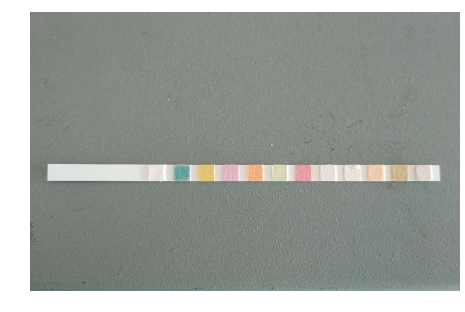

coeff = 0.24
dbil = 13
25


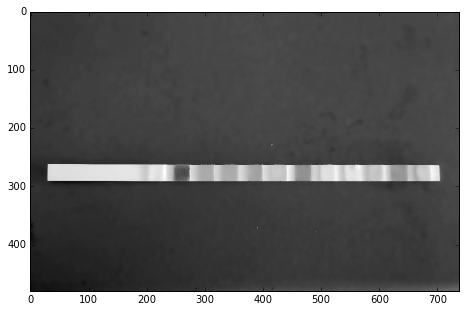

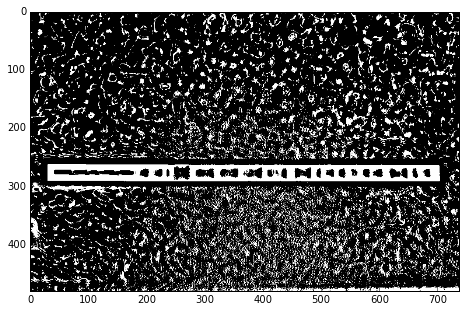

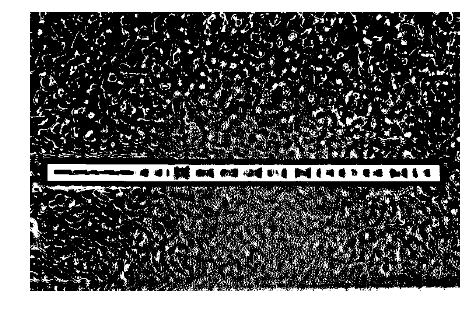

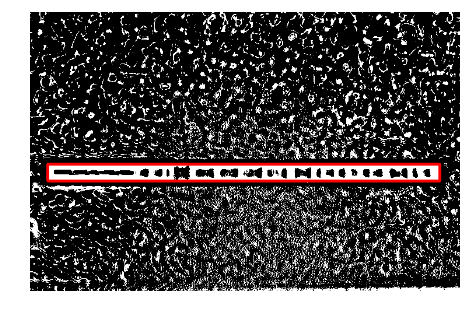

coeff = 0.24
dbil = 13
25


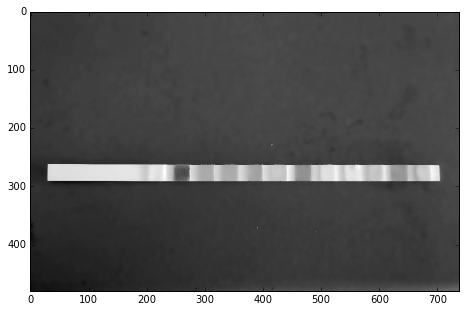

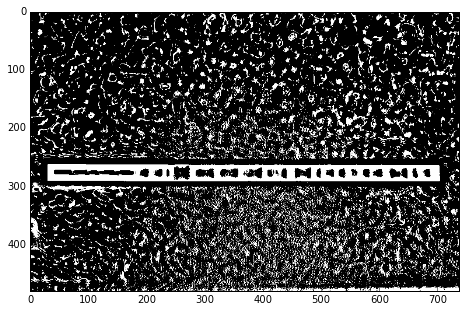

found rect is [[ 30 291]
 [ 30 262]
 [702 262]
 [702 291]]
[1, 2, 3, 0]
[[ 30 291]
 [ 30 262]
 [702 262]
 [702 291]]
[[ 30 262]
 [702 262]
 [702 291]
 [ 30 291]]
[[   0.89285714    0.          -26.78571429]
 [   0.            0.86206897 -225.86206897]
 [   0.            0.            1.        ]]


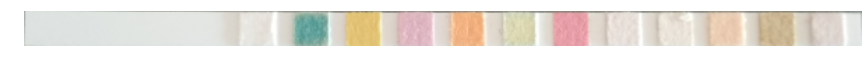

In [297]:
for images_name in images_names:
    image = cv2.cvtColor(cv2.imread(images_name, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    image = resize(image, 480)
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    
    image_binary = binarize(image)
    plt.axis('off')
    plt.imshow(image_binary, cmap='gray')
    plt.show()
    
    image_contoured = draw_largest_contour(image_binary)
    plt.axis('off')
    plt.imshow(image_contoured)
    plt.show()
    
    image_warped = warp_image(image)
    plt.axis('off')
    plt.imshow(image_warped, cmap='gray')
    plt.show()